In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### データの用意

In [3]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_train.dtype

dtype('uint8')

In [6]:
# 平坦化
X_train = X_train.reshape(-1, 784)
X_valid = X_valid.reshape(-1, 784)

In [7]:
# 0-1化
X_train = X_train.astype(float) / 255
X_valid = X_valid.astype(float) / 255

In [8]:
# 分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)


In [9]:
# one-hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_valid_one_hot = enc.transform(y_valid[:, np.newaxis])
print(X_train.shape)
print(y_train_one_hot.shape)
print(X_valid.shape)
print(y_valid_one_hot.shape)

(48000, 784)
(48000, 10)
(12000, 784)
(12000, 10)


### ミニバッチイテレータ

In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 課題

In [11]:
# ニューラルネットワークスクラッチ
class ScratchSimpleNeuralNetrowkClassifier:

    def __init__(self, features=784, nodes1=400, nodes2=200, n_output=10, sigma=0.01, activate="tanh", verbose=False):
        self.n_features = features
        self.n_nodes1 = nodes1
        self.n_nodes2 = nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.act = activate
        self.verbose = verbose
        self._init_weight()

    def _init_weight(self):
        self.W1 = np.random.normal(size=(self.n_features, self.n_nodes1), scale=self.sigma)
        self.b1 = np.zeros(self.n_nodes1)
        self.W2 = np.random.normal(size=(self.n_nodes1, self.n_nodes2), scale=self.sigma)
        self.b2 = np.zeros(self.n_nodes2)
        self.W3 = np.random.normal(size=(self.n_nodes2, self.n_output), scale=self.sigma)
        self.b3 = np.zeros(self.n_output)

    def _activation(self, X):
        if self.act == "sigmoid":
            return 1 / (1 + np.exp(-X))
        elif self.act == "tanh":
            return np.tanh(X)

    def _softmax(self, X):
        # -max(X) によって発散を抑える
        return np.exp(X - np.max(X)) / np.sum(np.exp(X - np.max(X)), axis=1, keepdims=True)

    # 交差エントロピー誤差
    def _loss_function(self, y, yt):
        eps = 1e-8
        return -np.mean(yt * np.log(y + eps))

    def _gradient_descent(self, X, y, yt, lr):

            # 3rd layer
            delta_a3 = (y-yt)/ len(y)
            delta_b3 = np.sum(delta_a3,axis=0)
            delta_W3 = np.dot(self.z2.T,delta_a3)
            delta_z2 = np.dot(delta_a3,self.W3.T)
        
            self.W3 -= lr * delta_W3
            self.b3 -= lr * delta_b3
        
            # 2nd layer
            if self.act == 'sigmoid':
                delta_a2 = delta_z2*(1-self._activation(self.z2))*self._activation(self.z2)
            
            elif self.act == 'tanh':
                delta_a2 = delta_z2*(1-np.tanh(self.z2)**2)

            delta_b2 = np.sum(delta_a2,axis=0)
            delta_W2 = np.dot(self.z1.T,delta_a2)
            delta_z1 = np.dot(delta_a2,self.W2.T)

            self.W2 -= lr * delta_W2
            self.b2 -= lr * delta_b2

            # 1st layer
            if self.act == 'sigmoid':
                delta_a1 = delta_z1*(1-self._activation(self.z1))*self._activation(self.z1)
            
            elif self.act == 'tanh':
                delta_a1 = delta_z1*(1-np.tanh(self.z1)**2)
                
            delta_b1 = np.sum(delta_a1,axis=0)
            delta_W1 = np.dot(X.T,delta_a1)
        
            self.W1 -= lr * delta_W1
            self.b1 -= lr * delta_b1

    def fit(self, X, y, X_val=None, y_val=None, n_epoch=50, n_batch=20, lr=0.01):
        # 重みの初期化
        self._init_weight()
        # 各エポックの loss を記録するリスト
        self.log_loss = []
        self.log_loss_val = []
        # エポックごとの指標値を評価する: 精度
        self.log_acc = []
        self.log_acc_val = []
        
        for epoch in range(n_epoch):
            # ミニバッチ処理
            get_mini_batch = GetMiniBatch(X, y, batch_size=n_batch)
            
            self.loss = 0
            self.true_y = np.array([])
            self.pred_y = np.array([])
            
            for mini_X_train, mini_y_train in get_mini_batch:
                # forward
                self.z1 = self._activation(np.dot(mini_X_train, self.W1) + self.b1)
                self.z2 = self._activation(np.dot(self.z1, self.W2) + self.b2)
                y_hat = self._softmax(np.dot(self.z2, self.W3) + self.b3)
                # バックプロパゲーション（確率的勾配降下法）
                self._gradient_descent(mini_X_train, y_hat, mini_y_train, lr)
                # ミニバッチ データの正しい値と推定値を記録する
                self.true_y = np.concatenate([self.true_y, np.argmax(mini_y_train, axis=1)])
                self.pred_y = np.concatenate([self.pred_y, np.argmax(y_hat, axis=1)])
                # 損失関数
                self.loss += self._loss_function(y_hat, mini_y_train)

            # 各エポックの損失関数を記録する
            self.log_loss.append(self.loss / len(get_mini_batch))
            # 精度
            acc = accuracy_score(self.true_y, self.pred_y)
            self.log_acc.append(acc)
            
            # 検証データが入力されたら計算する
            if X_val is not None:
                # forward
                self.z1_val = self._activation(np.dot(X_val, self.W1) + self.b1)
                self.z2_val = self._activation(np.dot(self.z1_val, self.W2) + self.b2)
                y_hat_val = self._softmax(np.dot(self.z2_val, self.W3) + self.b3)
                # 損失関数
                self.loss_val = self._loss_function(y_hat_val, y_val)
                self.log_loss_val.append(self.loss_val)
                # 精度
                acc_val = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_hat_val, axis=1))
                self.log_acc_val.append(acc_val)

            # verbose を true に設定すると、学習過程などを出力する
            if self.verbose:
                print(f"epoch:{epoch:>3} loss:{(self.loss / n_batch):>8,.3f} acc:{acc:>5,.3f}")

    def predict(self, X):
        self.pred_z1 = self._activation(np.dot(X, self.W1) + self.b1)
        self.pred_z2 = self._activation(np.dot(self.pred_z1, self.W2) + self.b2)
        return np.argmax(np.dot(self.pred_z2, self.W3) + self.b3, axis=1)

### 学習させる

In [12]:
clf = ScratchSimpleNeuralNetrowkClassifier(features=784,
                                           nodes1=400, nodes2=200, n_output=10,
                                           sigma=0.01,
                                           activate='tanh',
                                           verbose = True)
clf.fit(X_train, y_train_one_hot, X_valid, y_valid_one_hot, n_epoch=30, n_batch=20, lr=0.01)

epoch:  0 loss:  19.442 acc:0.493
epoch:  1 loss:   6.221 acc:0.847
epoch:  2 loss:   4.572 acc:0.891
epoch:  3 loss:   4.024 acc:0.904
epoch:  4 loss:   3.687 acc:0.911
epoch:  5 loss:   3.430 acc:0.917
epoch:  6 loss:   3.227 acc:0.922
epoch:  7 loss:   3.059 acc:0.926
epoch:  8 loss:   2.911 acc:0.930
epoch:  9 loss:   2.773 acc:0.933
epoch: 10 loss:   2.641 acc:0.936
epoch: 11 loss:   2.511 acc:0.940
epoch: 12 loss:   2.383 acc:0.943
epoch: 13 loss:   2.258 acc:0.946
epoch: 14 loss:   2.139 acc:0.949
epoch: 15 loss:   2.026 acc:0.952
epoch: 16 loss:   1.920 acc:0.954
epoch: 17 loss:   1.821 acc:0.957
epoch: 18 loss:   1.730 acc:0.959
epoch: 19 loss:   1.645 acc:0.961
epoch: 20 loss:   1.567 acc:0.963
epoch: 21 loss:   1.493 acc:0.965
epoch: 22 loss:   1.425 acc:0.966
epoch: 23 loss:   1.361 acc:0.967
epoch: 24 loss:   1.300 acc:0.969
epoch: 25 loss:   1.244 acc:0.970
epoch: 26 loss:   1.191 acc:0.971
epoch: 27 loss:   1.140 acc:0.972
epoch: 28 loss:   1.093 acc:0.974
epoch: 29 loss

In [13]:
y_pred = clf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.960


### 学習曲線のプロット

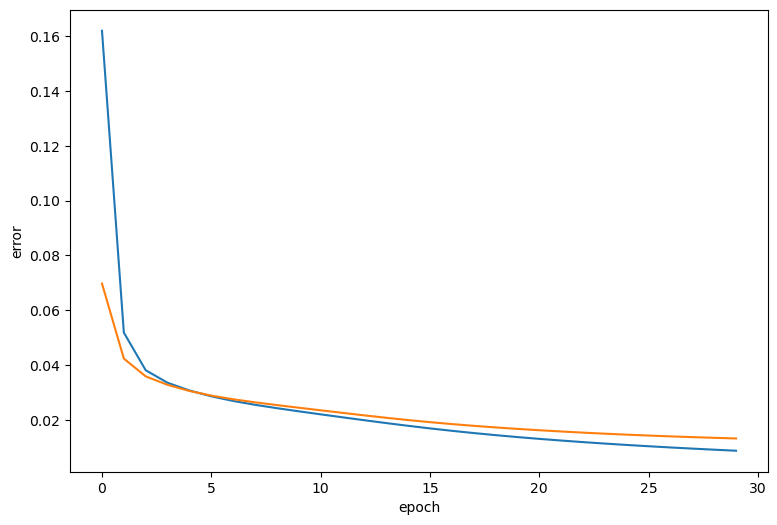

In [14]:
plt.figure(figsize=(9, 6))
plt.plot(clf.log_loss, label="train")
plt.plot(clf.log_loss_val, label="val")
plt.xlabel("epoch")
plt.ylabel("error")
plt.show()

汎化性能が特には悪化していないので、過学習はしていない